In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = os.path.join("..", "..", "..", "data")  # document-wide constants are uppercase by convention

# 1b
## i) Taking logs and plotting

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "oil_gold_2017.csv"), index_col = "DATE")
df.index = pd.DatetimeIndex(df.index, dayfirst=True).to_period('M')
df["LGOLD"] = np.log(df["GOLD"])
df["LOIL"] = np.log(df["OIL"])
df.tail()

,GOLD,OIL,LGOLD,LOIL
DATE,,,,
2016-06,1322.5,45.18,7.187279,3.810655
2016-07,1272.0,49.78,7.148346,3.907613
2016-08,1178.1,45.66,7.071658,3.821223
2016-09,1145.9,51.97,7.043946,3.950667
2016-10,1212.8,52.50,7.100687,3.960813


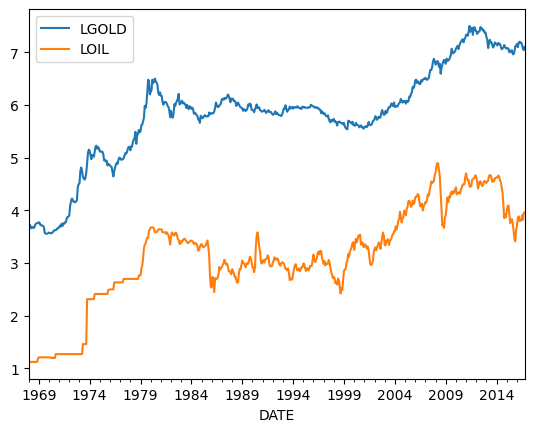

In [4]:
df[["LGOLD", "LOIL"]].plot();
#plt.savefig("oilgold2017.pdf")

Indeed the series appear to move together, so there may be an equilibrium relationship between them.

## ii) Unit root tests
The data seem to be trending upwards, so include a time trend along with the intercept (`regression='ct'`). If you were to conduct the test manually (such as in an exam), the relevant critical value would thus be -3.41.

In [5]:
ADF, p, crits, res = tsa.stattools.adfuller(df["LOIL"], regression='ct', autolag='AIC', store=True)
print("ADF = ", ADF, "\np   = ", p)

ADF =  -2.5524224546607397 
p   =  0.3022670842559252


In [6]:
ADF, p, crits, res = tsa.stattools.adfuller(df["LGOLD"], regression='ct', autolag='AIC', store=True)
print("ADF = ", ADF, "\np   = ", p)

ADF =  -2.559158224027972 
p   =  0.29904292389348935


Neither test rejects, so both series are I(1).
## iii) Long-run relationship
The long-run relationship is estimated as follows:

In [7]:
lr_model = smf.ols(formula="LOIL ~ LGOLD", data=df).fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   LOIL   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     4015.
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          6.99e-264
Time:                        17:34:03   Log-Likelihood:                -183.59
No. Observations:                 586   AIC:                             371.2
Df Residuals:                     584   BIC:                             379.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2590      0.086    -26.167      0.0

The cointegrating vector is $(1, -0.926)$. A plot of the residuals follows.

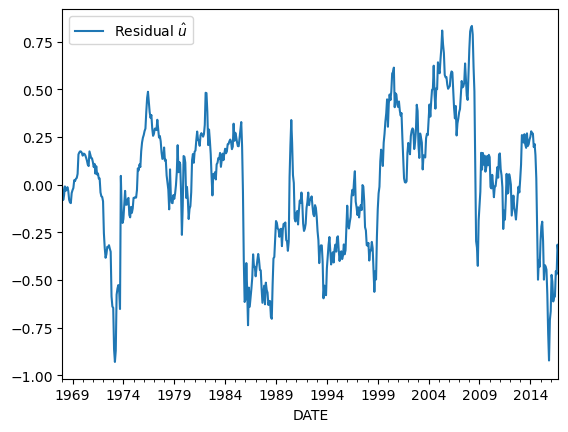

In [8]:
u = lr_model.resid
u.plot(label=r"Residual $\hat{u}$")
plt.legend();
#plt.savefig("uhat.pdf")

## iv) Engle-Granger test
The Engle-Granger test is just an ADF test, applied to the residuals $\hat{u}$. The null hypothesis is $H_0:$ "No cointegration".

In [9]:
ADF, p, crits, res = tsa.stattools.adfuller(u, regression='c', autolag='AIC', store=True)
print("ADF = ", ADF)

ADF =  -3.7247713389879844


Note that `adfuller` returns a $p$-value and critical values as well. I just chose not to print those, because it would be **wrong** to use them: since we are using `adfuller` to perform an Engle-Granger test by applying it to residuals, we have to use the Engle-Granger critical value, which is $-3.41$.

Since $-3.72<-3.41$, we reject the null and conclude that the variables are indeed cointegrated. Remember that we can look at the test regression of the ADF test as follows:

In [10]:
print(res.resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     11.53
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.23e-05
Time:                        17:34:04   Log-Likelihood:                 586.70
No. Observations:                 584   AIC:                            -1167.
Df Residuals:                     581   BIC:                            -1154.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0417      0.011     -3.725      0.0

Here, `y` stands for $\Delta \hat{u}_t$, `x1` stands for $\hat{u}_{t-1}$, and `x2` stands for $\Delta \hat{u}_{t-1}$. In an exam, I might just give you the output above. You'd then need to find the test statistic $-3.725$, and figure out to use the correct critical value from the Engle-Granger table.

Since this is not an exam, we can actually avoid having to save the residuals from the long-run relationship and calling `adfuller` on them manually alltogether, because `statsmodels` provides the Engle-Granger test directly via `coint` which combines these steps into one:

In [11]:
tsa.stattools.coint(df.LOIL, df.LGOLD, trend='c', autolag='aic')

(-3.7282350101883,
 0.016848769572813744,
 array([-3.91525916, -3.34659455, -3.05170786]))

For some reason, `statsmodels` uses a different critical value ($-3.35$ instead of $-3.41$). It also provides a $p$-value, 0.017. This one is fine to use, because it comes from the Engle-Granger distribution.
## v) Vector Error Correction Model
We first estimate the equation for `LOIL`. I'm throwing in a lag of $\Delta Y_{t}$ (`df.LOIL.diff().shift()`), because there is autocorrelation without it (try leaving it out and look at the DW statistic).

In [12]:
vecm1 = smf.ols(formula="df.LOIL.diff() ~ u.shift() + df.LOIL.diff().shift()", data=df).fit()
print(vecm1.summary())

                            OLS Regression Results                            
Dep. Variable:         df.LOIL.diff()   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     24.46
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           6.31e-11
Time:                        17:34:04   Log-Likelihood:                 654.56
No. Observations:                 584   AIC:                            -1303.
Df Residuals:                     581   BIC:                            -1290.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

The general form of the VECM equation is
$$
\Delta Y_t=c+\alpha_1\cdot (Y_{t-1}-\beta_1-\beta_2X_{t-1})+\gamma\Delta Y_{t-1} +e_{1t},
$$
where we substituted $\hat{u}_{t-1}$ for $(Y_{t-1}-\beta_1-\beta_2X_{t-1})$ for estimation. Plugging in $c=0.0036$, $\alpha_1=-0.035$, and $\gamma=0.25$ from the estimated VECM, as well as $\beta_1=-2.26$ and $\beta_2=0.926$ from the estimated long-run relationship, the estimated model is
$$
\Delta \textrm{loil}_t=0.0036-0.035\cdot(\textrm{loil}_{t-1}-0.926\textrm{lgold}_{t-1}+2.26)+0.25\Delta\textrm{loil}_{t-1}+e_{1t}.
$$
Note that $\alpha_1=-0.035<0$ as desired.


Next, we estimate the equation for `LGOLD`. Here, no lagged $\Delta Y_t$ seems to be needed as per the DW statistic:


In [13]:
vecm2 = smf.ols(formula="df.LGOLD.diff() ~ u.shift()", data=df).fit()
print(vecm2.summary())

                            OLS Regression Results                            
Dep. Variable:        df.LGOLD.diff()   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.616
Date:                Wed, 11 Oct 2023   Prob (F-statistic):              0.204
Time:                        17:34:04   Log-Likelihood:                 850.41
No. Observations:                 585   AIC:                            -1697.
Df Residuals:                     583   BIC:                            -1688.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0059      0.002      2.504      0.0

The estimated equation is
$$
\Delta \textrm{lgold}_t=0.0059+0.0090\cdot(\textrm{loil}_{t-1}-0.926\textrm{lgold}_{t-1}+2.26)+e_{2t}.
$$
However, note that $\hat{\alpha}_2$ is insignificant ($p$-value 0.204), so this second equation isn't really needed. This means that all the error correcting is done by the oil price. Our final model is thus the single-equation ECM
$$
\Delta \textrm{loil}_t=0.0036-0.035\cdot(\textrm{loil}_{t-1}-0.926\textrm{lgold}_{t-1}+2.26)+0.25\Delta\textrm{loil}_{t-1}+e_{1t}.
$$
This means that about 3.5% of the disequilibrium is corrected per month.

Overall conclusion: there is an equilibrium relationship between `loil` and `lgold`, with cointegrating vector $(1, -0.926)$. In case of a disequilibrium, `loil` adjusts towards the equilibrium. The
adjustment amounts to 3.5\% of the disequilibrium per period.